 # Annealing NP problems
 
In this notebook we take a look at a few of our favourite NP-Complete a and NP-Hard problems and and their solution with several annealing mechanisms. For a given problem, there are various mathematical formulations. For example [The paper by Lucas](https://arxiv.org/abs/1302.5843) describes a bunch of NP problems in terms of 2-local ising models. In this notebook we concentrate on the 2-local ising formulation of some problems, so that we can compare our homegrown simulated thermal annealing algorithm against Dwave's simulated quantum annealing.

First, let as import all the python modules we will need further down in the notebook

In [51]:
import numpy as np
import networkx as nx
from itertools import product
import dimod
import neal
from common.abstract_ising import AbstractIsing
from common.utils import *
from matplotlib.colors import Colormap, ListedColormap

and define a class for thermal annealing of ising models with 2-local hamiltonians

In [62]:
class TwoLocalIsing1D(AbstractIsing):
    def __init__(self, h, J):
        self.h, self.J = h, J
        self.num_spins = len(h)
                
        # initialize system at infinite temperature
        # i.e. spins are completely random and uncorrelated
        self.spins = 2*(np.random.rand(self.num_spins) < 0.5) - 1
    
    def energy(self, spins=None):
        """
        Args:
            spins: a single spin configuration, or a list of spin configurations
            
        Returns:
            Energies corresponding to the given spin configurations
        """
        if spins is None:
            spins = self.spins
            
        if len(spins.shape) == 1:
            spins = spins[None, :]
        
        energy = np.zeros(spins.shape[0])
        energy += np.einsum('i,bi->b', self.h, spins)
        energy += np.einsum('ij,bi,bj->b', self.J, spins, spins)
        return energy

    def energy_diff(self, i):
        dE = 0
        for coef in [self.h, self.J]:
            tmp = 0
            for j in range(len(coef.shape)):
                tmp += np.moveaxis(coef, j, 0)[i]
            for _ in range(len(coef.shape) - 1):
                tmp = tmp.dot(self.spins)
            dE += tmp     
        dE *= -2 * self.spins[i] 
        
        return dE
    
    def rand_site(self):
        """Selects a site in the lattice at random"""
        return (np.random.randint(self.num_spins),)
    
    def all_configurations(self):
        """Returns all possible spin configurations"""
        dim = np.arange(2 ** self.num_spins)
        space = ((dim[:, None] & (1 << np.arange(self.num_spins))) > 0)
        space = 2*space.astype(int) - 1
        return space

## Graph vertex Coloring

The problem of vertex coloring of a graph is stated as follows - given a graph $G=(V,E)$, and set of $n$ colors, is it possible to color the vertices of the graph with these colors so that to adjacent vertices (vertices connected with an edge) have the same color? This problem has a lot of pracical applications and is of high interest ([the wikipedia page](https://en.wikipedia.org/wiki/Graph_coloring) does a good job summarizing this, stuff, so we don't do it here). The problem of vertex coloring is known to be an NP-Complete problem.

To come up with annealing procedures for this problem, let us first summarize its 2-local ising formulation from Lucas' paper. 

To represent the problem as an Ising model we introduce binary variables $q_{v,i}$. The variable $q_{v,i}$ equals $1$ if the vertex $v$ is colored with color $i$, and $0$ otherwise, so we have total of $\vert V\vert n$ variables, where $\vert V\vert$ denotes the number of vertices in th$e graph.

The 2-local Ising hamiltonian for a graph coloring problem with $n$ colors is as follows

$$
H = \sum_{v \in V}\left( \sum_{i=0}^{n-1}q_{v,i} - 1 \right)^2 + \sum_{u,v \in E}\sum_{i=0}^{n-1}q_{u,i}q_{v,i}
$$

The first term in this hamiltonian makes sure, that eaxch vertex is colored withonly one color, and the second term makes sure, that the pairs of vertices at the ends of an edge do not have the same color.

To proceed further, let us simplify the hamiltonian a little bit, namely simplify the first term

$$
\sum_{v \in V}\left( \sum_{i=0}^{n-1}q_{v,i} - 1 \right)^2 = \sum_{v \in V} \left( \sum_{i,j=0;i\ne j}^{n-1}q_{v,i}q_{v,j}-\sum_{i=0}^{n-1}q_{v,i} + 1 \right) = \sum_{v \in V}\sum_{i,j=0;i\ne j}^{n-1}q_{v,i}q_{v,j} - \sum_{v \in V}\sum_{i=0}^{n-1}q_{v,i} + \vert V \vert
$$
Here, we have taken into account the fact, that for a binary fariable $x^2=x$. Throwing away the constant term $\vert V \vert$, we have the following hamiltonian

$$
H = - \sum_{v \in V}\sum_{i=0}^{n-1}q_{v,i}+\sum_{v \in V}\sum_{i,j=0;i\ne j}^{n-1}q_{v,i}q_{v,j} + \sum_{u,v \in E}\sum_{i=0}^{n-1}q_{u,i}q_{v,i}
$$

Let us generate a random graph using the module networkx

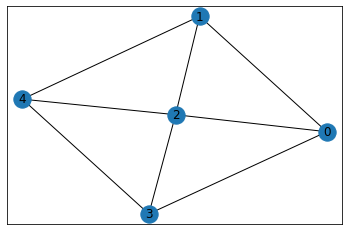

In [83]:
node_count = 5
edge_prob = 0.5

graph = nx.generators.random_graphs.erdos_renyi_graph(node_count, edge_prob)
nx.draw_networkx(graph)

Let us define a function, which takes as argument a `networkx` graph, and returns the linear and quadratic coefficients $h$ and $J$ for the 2-local ising model defined above.

In [84]:
def get_coefficients(graph, color_count):
    
    node_count = graph.number_of_nodes()
    var_count = node_count * color_count
    
    q = np.arange(var_count).reshape(node_count, color_count)
    h = -1 * np.ones(var_count)
    J = np.zeros((var_count, var_count))

    for (u, v) in graph.edges:
        for (i, j) in product(range(color_count), repeat=2):
            if i != j:
                J[q[i, j], ]

    for v in graph.nodes:
        for i,j in product(range(color_count), repeat=2):
            if i != j:
                J[q[v, i], q[v, j]] = 1

    for (u, v) in graph.edges:
        for i in range(color_count):
            J[q[u, i], q[v, i]] += 1
            
    return h, J

Run on dwave, take 100 samples, and chose the one with lowest energy

In [85]:
color_count = 3
h, J = get_coefficients(graph, color_count)
bqm = dimod.BinaryQuadraticModel(h, J, 0.0, dimod.BINARY)
sampler = neal.SimulatedAnnealingSampler()
sampleset = sampler.sample(bqm, num_reads=100)

result = list(sampleset.lowest().first.sample.values())
colors = []
for v in graph.nodes():
    color = result[color_count * v:color_count * v + color_count]
    color = int('0b' + ''.join(map(str, color)), 2)
    colors.append(color)

# Normalize
_max = max(colors)
colors = [color / _max for color in colors]

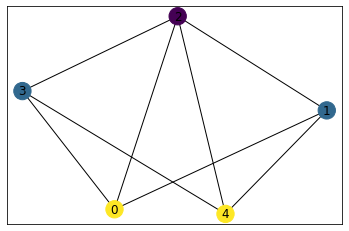

In [86]:
nx.draw_networkx(graph, node_color=colors)

Now let us run with simulated thermal annealing

In [98]:
ising = TwoLocalIsing1D(h, J)

T, _ = exp_decay_schedule(300, 100, 0.01)
E, spins = anneal(ising, T, 5)

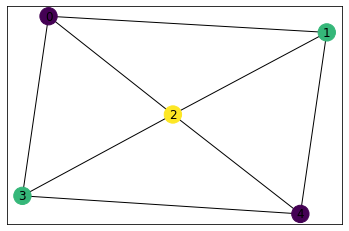

In [99]:
result = (spins + 1) // 2
colors = []
for v in graph.nodes():
    color = result[color_count * v:color_count * v + color_count]
    color = int('0b' + ''.join(map(str, color)), 2)
    colors.append(color)

# Normalize
_max = max(colors)
colors = [color / _max for color in colors]
nx.draw_networkx(graph, node_color=colors)